In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from matplotlib import gridspec
from matplotlib.dates import WeekdayLocator, DayLocator, HourLocator, DateFormatter, drange, date2num, num2date
from matplotlib.ticker import FormatStrFormatter
from pythermalcomfort.models import utci
from matplotlib.patches import Circle, Ellipse, Rectangle

import os, sys, inspect
HERE_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.append(HERE_PATH)
from droplet import droplet

path = "/Users/milan/git/AthleticsChampionshipsHeat/data/"

In [3]:
## LOAD DATA
events = ["berlin2009","daegu2011","helsinki2012","moscow2013","zuerich2014",
          "amsterdam2016","berlin2018","berlin2018fc"]
events_long = ["WOC Berlin 2009","WOC Daegu 2011","EOC Helsinki 2012","WOC Moscow 2013","EOC Zürich 2014",
        "EOC Amsterdam 2016", "EOC Berlin 2018","Berlin 2018, forecast from day 0"]
alphabet = ["a","b","c","d","e","f","g","h"]

t0 = datetime.datetime(1900,1,1)               # netCDF is in hours since

tstarts = [datetime.datetime(2009,8,15,0),     # start day of the event
           datetime.datetime(2011,8,27,0),
           datetime.datetime(2012,6,27,0),
           datetime.datetime(2013,8,10,0),
           datetime.datetime(2014,8,12,0),
           datetime.datetime(2016,7,6,0),
           datetime.datetime(2018,8,6,0),
           datetime.datetime(2018,8,6,0)]

tends = [datetime.datetime(2009,8,23,23),       # end day of the event
         datetime.datetime(2011,9,4,23),
         datetime.datetime(2012,7,1,23),
         datetime.datetime(2013,8,18,23),
         datetime.datetime(2014,8,17,23),
         datetime.datetime(2016,7,10,23),
         datetime.datetime(2018,8,12,23),
         datetime.datetime(2018,8,13,1)]

tends = [tend + datetime.timedelta(hours=1) for tend in tends]

utcs = [2,9,3,4,2,2,2,2]

UTCIs = []
times = []

for i,event in enumerate(events):
    F = np.load(path+event+"utci.npz")
    UTCIs.append(F["UTCI"])
    
    ncfile = nc.Dataset(path+event+".nc")
    time_hours = ncfile.variables["time"][:]
    ncfile.close()
    
    utc_td = datetime.timedelta(hours=utcs[i])        # convert utc from int to timedelta
    time_utc = [t0+datetime.timedelta(hours=np.float64(i)) for i in time_hours]   # time in utc
    time = [t+utc_td for t in time_utc] 
    times.append(time)


## MASK SOME DATA, apply land-sea mask for Helsinki 

# mask = np.zeros_like(UTCI)
# mask[:,3:,:] = np.nan
# mask = np.isnan(mask)
# UTCI = np.ma.masked_array(UTCI,mask=mask)

UTCIs[2][:,3:,:] = np.nan
UTCIs[5][:,0,4] = np.nan

def temp_plotter(ax, dates, tlow, thigh, tstart, tend):
    
    # these temperatures will be associated with the lower and upper end of the colormap
    clev = [10,32]
    tmin,tmax = (-100,100)   # absurdly low and high temperatures  
    cmap = "rainbow"
    cmat = [[clev[0],clev[0]],[clev[1],clev[1]]]
    cmat_high = clev[1]*np.ones((2,2))
    cmat_low = clev[0]*np.ones((2,2))
    
    ax.contourf([tstart,tend-dt],clev,cmat,128,cmap=cmap)
    ax.contourf([tstart,tend-dt],[clev[1],tmax],cmat_high,128,vmin=clev[0],vmax=clev[1],cmap=cmap)
    ax.contourf([tstart,tend-dt],[tmin,clev[0]],cmat_low,128,vmin=clev[0],vmax=clev[1],cmap=cmap)
    
    ylim = ax.get_ylim()
    d = 0.01
    mask = [date >= tstart and date <= tend for date in dates]
    dates_masked = [date for date,m in zip(dates,mask) if m]
    tlow = tlow[np.array(mask)]
    thigh = thigh[np.array(mask)]
    
    n_tsteps = len(dates_masked)
    
    # plot first half from the bottom, the first without transparency
    ax.fill_between(dates_masked,ylim[0]*np.ones(n_tsteps),tlow,facecolor="w",alpha=1.,edgecolor="grey")
    ax.fill_between(dates_masked,thigh,ylim[1]*np.ones(n_tsteps),facecolor="w",alpha=1.,edgecolor="grey")

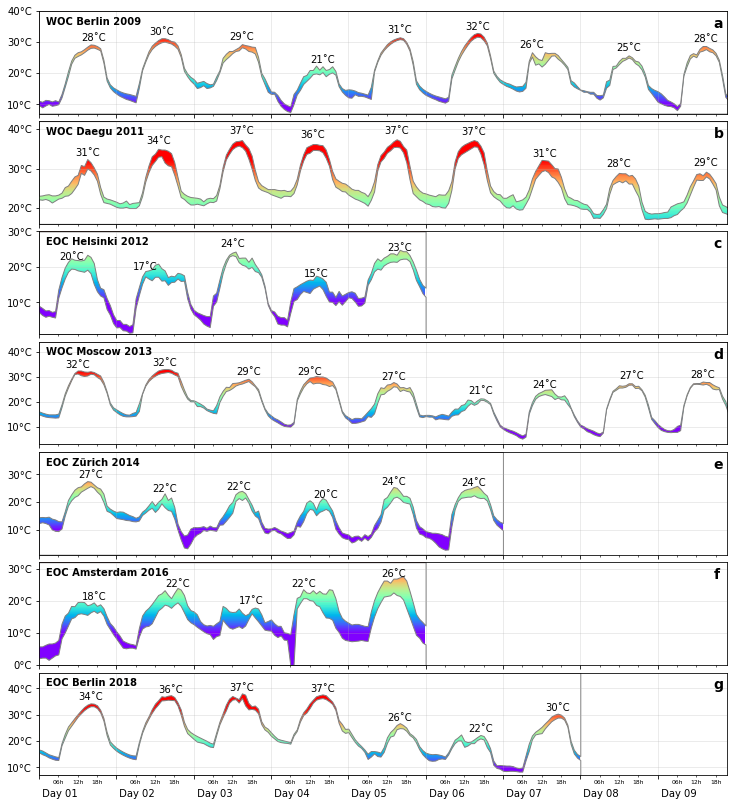

In [5]:
t0 = datetime.datetime(2000,1,1)
dt = datetime.timedelta(hours=0.1)

## PLOT
fig,axs = plt.subplots(7,1,figsize=(10,11),sharex=True)

# LABEL FORMATTING
for i,event in enumerate(events[:-1]):
    axs[i].yaxis.set_major_formatter(FormatStrFormatter('%d'+u'\N{DEGREE SIGN}'+'C'))
    axs[i].grid(alpha=0.3)
    axs[i].text(0.01,0.87,events_long[i],transform=axs[i].transAxes,fontweight="bold")
    axs[i].text(0.98,0.84,alphabet[i],transform=axs[i].transAxes,fontweight="bold",fontsize=14)

# LIMITS
axs[-1].set_xlim(t0,t0+datetime.timedelta(days=8.9))
axs[0].set_ylim(7,40)
axs[1].set_ylim(16,42)
axs[2].set_ylim(1,30)
axs[3].set_ylim(3,44)
axs[4].set_ylim(1,38)
axs[5].set_ylim(0,32)
axs[6].set_ylim(7,46)
# axs[7].set_ylim(7,46)

# DATA PLOTTING
for i,event in enumerate(events[:-1]):
    tidays = [t0+(times[i][j]-tstarts[i]) for j in range(1,len(times[i]))]
    utci = UTCIs[i]
    length_of_event = tends[i]-tstarts[i]
    ndays = length_of_event.days
    event_mask = [(t-t0) <= length_of_event and t >= t0 for t in tidays]
    
    utci = utci[np.array(event_mask),:,:]
    tidays = [t for t,m in zip(tidays,event_mask) if m]

    if i < 7:  # observed UTCIs
        utcim = utci[:,2,2]
        utcimin = np.nanmin(utci,axis=(1,2))
        utcimax = np.nanmax(utci,axis=(1,2))
    else:      # forecast
        utcim = np.mean(utci[:,:,2,2],axis=1)
        utcimin = np.percentile(utci[:,:,2,2],10,axis=1)
        utcimax = np.percentile(utci[:,:,2,2],90,axis=1)
    
    # temperature shaded curve
    temp_plotter(axs[i],tidays,utcimin,utcimax,t0,t0+length_of_event)
    
    # daily max as text
    for n in range(ndays):
        # find maximum
        utci_of_day_n = np.array([[u,t] for u,t in zip(utcim,tidays) if t.day-1 == n])
        daily_max = np.max(utci_of_day_n[:,0])
        t_of_dailymax = utci_of_day_n[np.argmax(utci_of_day_n[:,0]),1]
        axs[i].text(t_of_dailymax,daily_max+2,"{:d}˚C".format(np.int(np.round(daily_max))),ha="center")

axs[-1].xaxis.set_minor_locator(HourLocator(np.arange(6, 25, 6)))    # minor
axs[-1].xaxis.set_minor_formatter(DateFormatter("%Hh"))
axs[-1].xaxis.set_tick_params(which='minor', direction='out',pad=2,labelsize=6)

plt.setp(axs[-1].get_xticklabels(), ha="left")
axs[-1].xaxis.set_tick_params(which='major', direction='out',pad=10,labelsize=10)
axs[-1].xaxis.set_major_formatter(DateFormatter(" Day %d"))

axs[3].set_yticks([10,20,30,40])

plt.tight_layout(pad=0)
plt.savefig("meteograms.pdf")

__Fig. X__: The perceived temperature measured as universal thermal climate index (UTCI) for all competition days of different World and European Championships in Athletics. Colour shading reflects temperature. Width of the shading represents the minimum-maximum range of UTCI within 25km from the respective stadium in (a)-(g). (h) Forecast of UTCI based on the ECMWF ensemble prediction system initialised at noon on day 0.